# When do I stop Bayesian optimization?
Knowing when to quit is an important skill. In terms of optimization problems, knowing when you've found a solution is typically driven by "empirical" concerns: when have you run out of resources or patience. 

Here, we explore whether a key feature of Bayesian optimization - predictions of the outcome of an experiment and with an uncertainty - can be used to provide more rigor around when to stop optimizing.

In [1]:
%matplotlib inline
from matplotlib import pyplot as plt
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import Matern
from sklearn.model_selection import train_test_split
from time import perf_counter
from scipy import stats
from tqdm import tqdm
import pandas as pd
import numpy as np

In [2]:
np.random.seed(32)

## First, building a Gaussian process function on an example dataset.
We use the target function from [modAL's documentation](https://modal-python.readthedocs.io/en/latest/content/examples/bayesian_optimization.html) as an example.
The goal of this problem is to find a point that maximizes a function.

In [3]:
X = np.linspace(0, 20, 128)
y = np.sin(X)/2 - ((10 - X)**2)/50 + 2

In [4]:
X = np.expand_dims(X, 1)  # Makes X into a 2D array, as expected by sklearn

Pick a few points and train an initial model

In [5]:
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=5)

In [6]:
kernel = Matern()
model = GaussianProcessRegressor(kernel=kernel)

In [7]:
model.fit(X_train, y_train)

GaussianProcessRegressor(kernel=Matern(length_scale=1, nu=1.5))

Plot the results

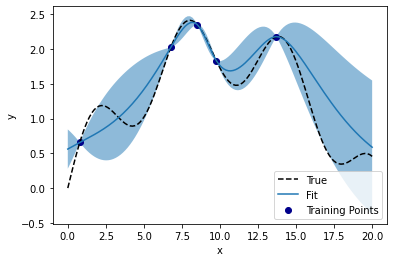

In [8]:
fig, ax = plt.subplots()

ax.plot(X, y, 'k--', label='True')

y_pred, y_std = model.predict(X, return_std=True)
ax.plot(X, model.predict(X), label='Fit')
ax.fill_between(X[:, 0], y_pred - y_std, y_pred + y_std, alpha=0.5)
ax.scatter(X_train, y_train, label='Training Points', color='darkblue')

ax.set_xlabel('x')
ax.set_ylabel('y')
ax.legend()

As you can see, there are many points in our search space between 0 and 20 that look like they would improve off our current best point in the training set.

## An easy route: Assume every prediction is independant
A first approach to estimating the whether any point is likely to beat a threshold is to compute the probability that each will exceed it and then combine the predictions to get the probability that *any* is above.

If the probabilities are independent (spoiler: they are not), this is an easy computation. Then the probability of any of $N$ points being above the threshold is one minus the probability of all being below. If we denote the probability of point $i$ in our search space being below the threshold as $P^{\mathrm{fail}}_i$, the probability of all being below is:

$P^{\mathrm{all-fail}} = \prod^N_i P^{\mathrm{fail}}_i$

This is easy to compute using our GPR model, which gives us the standard deviation and mean of the predicted value of each point. The probability distribution of expected values is Gaussian and we can compute the probability for each being above a threshold analytically.

In [9]:
y_mean, y_std = model.predict(X, return_std=True)
y_dist = stats.norm(loc=y_mean, scale=y_std ** 2)

In [10]:
thr = 2.5
y_prob = y_dist.cdf(thr)  # Use the cumulative distribution function to compute P(y<thr)

Text(0.5, 0, 'x')

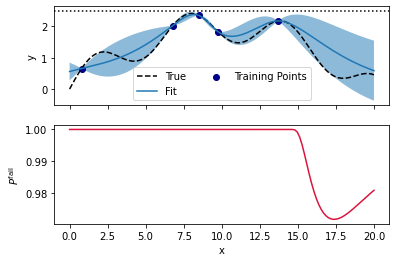

In [11]:
fig, axs = plt.subplots(2, 1, sharex=True)

# Plot the true function
ax = axs[0]
ax.plot(X, y, 'k--', label='True')

# Plot the predictions
ax.plot(X, model.predict(X), label='Fit')
ax.fill_between(X[:, 0], y_mean - y_std, y_mean + y_std, alpha=0.5)
ax.scatter(X_train, y_train, label='Training Points', color='darkblue')
ax.set_xlim(ax.get_xlim())
ax.plot(ax.get_xlim(), [thr]*2, 'k:')

ax.set_ylabel('y')
ax.legend(ncol=2)

ax = axs[1]

ax.plot(X, y_prob, color='crimson')
ax.set_ylabel('$P^{\mathrm{fail}}$')
ax.set_xlabel('x')

See how the probability of failure is lowest where the distribution lies close to the threshold line at $y=2.5$

As stated above, we compute the probability of *all* being below a certain value by multiplying each of the probabilities.

In [12]:
ind_fail_prob = np.prod(y_prob)
print(f'Probability of all being below {thr}: {ind_fail_prob * 100:.1f}%')

Probability of all being below 2.5: 49.6%


Despite the probability of the best point being above the threshold is only 2%, we compute a probability of all failing of 49%. This sounds suspect.

It is also not surprising. If you repeat an experiment with a 1% chance of success 64 times, you have a $(0.01)^{64} \approx 52\%$ chance of one experiment working *if they are all truly independent*.

## The problem: Measurements are correlated
Thinking metaphorically, the predicted values of nearly similar points should always be similar. Speaking mathematically, they should be correlated.

The reason this is true is that the predictions of the models are based on the same parameters. Using a linear function as an example, the predicted values for two points, $x_1$ and $x_2$, have values of $y_1 = mx_1 + b$ and $y_2 = mx_2 + b$. You can see how their values are related. 

The uncertainties of these values are even related. We compute the uncertainty of $y_1$ and $y_2$ due to uncertainty in $m$ and $b$ using partial derivatives: 

$\sigma^2_{y_1} = x_1 \sigma^2_m + \sigma_b$

$\sigma^2_{y_2} = x_2 \sigma^2_m + \sigma_b$

So, it isn't just that the values are related. The variance/uncertainty in the values are also driven from a similar source. 

We, therefore, must capture the covariance between predicted values to reflect how multiple predictions will vary in similar ways due to their dependence on similar parameters.

*Advanced note*: We can compute the covariance analytically by [computing the Jacobian matrix](https://en.wikipedia.org/wiki/Propagation_of_uncertainty#Non-linear_combinations) of how predicted values for different points are affected by parameter uncertainty. If you're not perusaded by the above explanation, you can prove the covariance for linear models (and many other model forms) are nonzero using this method.

## The solution: Multivariate normal distributions
We can solve our covariance problem using [Multivariate normal distributes](https://en.wikipedia.org/wiki/Multivariate_normal_distribution). These functions capture how the probability of different events happening are related.

For example, the value of a point being below the threshold and its immediate neighbor being above is less likely than both being below. 

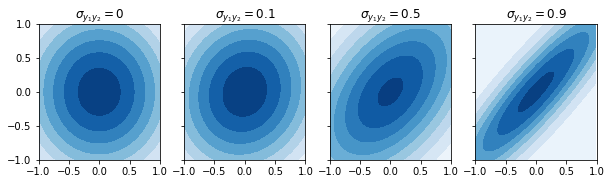

In [13]:
fig, ax = plt.subplots(1, 4, sharey=True, sharex=True, figsize=(10, 2.5))

x_grid, y_grid = np.mgrid[-1:1:.01, -1:1:.01]
pos = np.dstack((x_grid, y_grid))

for cov, ax in zip([0, 0.1, 0.5, 0.9], ax):
    rv = stats.multivariate_normal([0, 0], [[1.0, cov], [cov, 1.0]])
    ax.contourf(x_grid, y_grid, rv.pdf(pos), cmap='Blues')
    ax.set_title(f'$\sigma_{{y_1y_2}} = {cov}$')
    ax.set_xlim(-1, 1)
    ax.set_ylim(-1, 1)

See how the probability of $y_1$ being large and $y_2$ being small decreases as we increase the covariance ($\sigma_{{y_1y_2}}$) between the two values.

Noting how the values are no longer independant, we must compute the probability using the joint distribution. We can no longer compute the probabilities of failure separately then multiple them because they are no longer independent.

Thanks to SciPy, this is easy. We just create an object that describes the distribution and then ask for the cumulative distribution function for each value in the distribution (i.e., $y_1$ and $y_2$) being less than a threshold

In [14]:
grid_thr = 0.9
p_y1_fail = stats.norm(0, 1).cdf([grid_thr])
p_ind = p_y1_fail ** 2

Text(0, 0.5, 'Probability of both < 2.5')

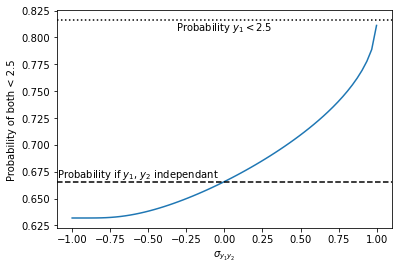

In [15]:
fig, ax = plt.subplots()

# Compute the likelihood of both failing
covs = np.linspace(-0.999, 0.999, 64)
values = [
    stats.multivariate_normal([0, 0], [[1.0, cov], [cov, 1.0]]).cdf([grid_thr]*2)
    for cov in covs
]

# Plot that
ax.plot(covs, values)

# Plot the independent
ax.set_xlim(ax.get_xlim())
ax.plot(ax.get_xlim(), [p_ind]*2, 'k--')
ax.text(-1.1, p_ind, f'Probability if $y_1$, $y_2$ independant', ha='left', va='bottom')

ax.plot(ax.get_xlim(), [p_y1_fail]*2, 'k:')
ax.text(0.0, p_y1_fail, f'Probability $y_1 < {thr}$', ha='center', va='top')


ax.set_xlabel('$\sigma_{{y_1y_2}}$')
ax.set_ylabel(f'Probability of both < {thr}')

Note how the probability of both $y_1$ and $y_2$ being less than 0.9 increases as the correlation between them increases. In fact, it approaches the probability that $y_1$ is less than the threshold. This makes sense in that if $y_2$ is closely correlated to $y_1$ then if $y_1$ fails so should $y_2$.

## Circling Back to the Original Porblem
With that theory and implementation done, let's re-consider the probability of an improved experiment.

Fortunately, Scikit-Learn will compute the covaraince between predictions for us.

In [16]:
y_mean, y_cov = model.predict(X, return_cov=True)
y_dist = stats.multivariate_normal(mean=y_mean, cov=y_cov, allow_singular=True)

In [17]:
%%time
thr = 3
start_time = perf_counter()
full_fail_prob = y_dist.cdf([thr]*X.shape[0]) # Probability of all variables being below thr
full_runtime = perf_counter() - start_time

CPU times: user 13min 41s, sys: 1.35 s, total: 13min 42s
Wall time: 13min 36s


In [18]:
print(f'Probability of all failing, considering covariance: {full_fail_prob * 100:.2f}%')

Probability of all failing, considering covariance: 96.14%


Excellent! We now compute a more reasonable probability of all failing of 96%!

### Improving computational efficiency
One thing to note is that the computation takes a long time to compute. Computing the CDF requires with $N$ predictions requires solving an $N$-dimenisonal integral, which is computationally expensive and slow even though that part of SciPy is written in FORTRAN. So, we need an approximation.

Given how the GPR works, points with similar input values are going to be more strongly correlated (it has to do with the GPR's functional form being a sum over radial basis functions). Consequently, we can assume the predictions of points far from each other to be independent.

We will use that nature to make an approximation. We compute the probability of a subset of points from the search space to fail to exceed of threshold using the covariance. We then draw a subset of remaining points, compute its probability of failure, and then repeat until we sample all points from the search space. We can approximate the probability of each subset to be independent if the points are sufficiently far apart, which means the probability of *all* subsets failing can be computed by multiplying them together (just like we did earlier).

In [19]:
def compute_failure_prob_using_chunks(model: GaussianProcessRegressor, X: np.ndarray, n_chunks: int, thr: float) -> float:
    """Compute the probability of all points in a search space being below a threshold.
    
    Uses a chunked approach where we group points together by similarity to treat as 
    correlated experiments. The different groups are treated as uncorrelated for 
    computational efficiency. Larger number of groups will lead to faster computation
    as you consider a fewer number of covariances between experiments.
    
    Note that an implementation of this strategy where X is multidimensinal might want to use
    some kind of clustering to find good chunks rather than just splitting them by rows.

    Args:
        model: Gaussian process regression model
        X: Search space, assumed to be sorted such that nearby rows are similar
        n_chunks: Number of chunks to use
        thr: Target threshold to be above
    Returns:
        Probability that all points will be below the threshold
    """
    
    chunk_probs = []
    for X_chunk in np.array_split(X, n_chunks):
        y_mean, y_cov = model.predict(X_chunk, return_cov=True)
        y_dist = stats.multivariate_normal(mean=y_mean, cov=y_cov, allow_singular=True)
        chunk_probs.append(y_dist.cdf([thr]*X_chunk.shape[0]))
        
    return np.prod(chunk_probs)

In [20]:
chunk_results = []
for n in tqdm([1, 2, 4, 8, 16, 32, 64, 128]):
    start_time = perf_counter()
    my_fail_prob = compute_failure_prob_using_chunks(model, X, n, thr)
    runtime = perf_counter() - start_time
    chunk_results.append({
        'chunks': n,
        'fail_prob': my_fail_prob,
        'runtime': runtime
    })

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 8/8 [19:17<00:00, 144.66s/it]


In [21]:
chunk_results = pd.DataFrame(chunk_results)

Text(0.5, 0, 'N Chunks')

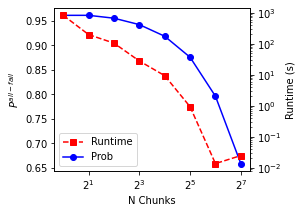

In [22]:
fig, ax = plt.subplots(figsize=(3.5, 3))

ax2 = ax.twinx()
rt, = ax2.loglog(chunk_results['chunks'], chunk_results['runtime'], 'rs--', label='Runtime')
ax2.set_ylabel('Runtime (s)')

pl, = ax.semilogx(chunk_results['chunks'], chunk_results['fail_prob'], 'bo-', base=2, label='Prob.')
ax.set_ylabel('$P^{all-fail}$')
ax.legend((rt, pl), ('Runtime', 'Prob'))

ax.set_xlim(ax.get_xlim())
ax.set_xlabel('N Chunks')

We can get close to the true success probability with a fraction of the computational cost using this approximate approach.

### Even Faster: Avoid Solving the Integral

**TODO (wardlt)**: On later reading, the logic here is wrong. GPR is not built on a covariance matrix of model parameters and is, instead, generates covariance matrices of predictions. However flawed the motivation, the results of this experiment show that we can accelerate the solution of the CDF integral using a Monte Carlo sampling rather than

The slow step in the above computations is solving the cumulative distribution function, which involves computing the area under a multidimensional integral. 
Instead of solving that integral exactly, we can approximate it by [drawing samples from Gaussian Process Regression](https://scikit-learn.org/stable/modules/generated/sklearn.gaussian_process.GaussianProcessRegressor.html#sklearn.gaussian_process.GaussianProcessRegressor.sample_y) and measuring the cumulative number that fall beneath our target threshold.
Such an approach relies on performing inference from the GPR model many times in contrast to only performing inference once in the previous example.
If inference is fast and the number we need to draw to converge is small, then this method will be faster than our previous implementations.
Worst case: running many inference samples is at least pleasingly parallel.

Speaking more formally, relying on sampling predictions from the model is conceptually very different from our previous implementation that involved probability distributions of predictions. 
Instead, we leverage how Gaussian processes are built on probability distributions of model parameters to ask "what is the likelihood of a model which predicts a value over our threshold."
We can solve this question using a Monte Carlo procedure:
1. Draw a sample of potential model parameters
1. Evaluate all points in the search space
1. Record whether any where above the threshold
1. Repeat from step 1 until we have recorded an adaquate number of samples
1. Average values from all sampled models


In [23]:
def compute_failure_prob_using_sampling(model: GaussianProcessRegressor, X: np.ndarray, thr: float, n_samples: int = 256, entries_per_batch: int = 16384, samples_per_batch: int = 16) -> float:
    """Compute the probability of all points in a search space being below a threshold.
    
    Use a sampling technique were we sample the posterior of the Gaussian process model many times
    and evaluate whether all entries are below the threshold for that set of parameters.
    
    We use a few different performance optimizations to compute this integral quickly and 
    with limited memory: 
    1. We only evaluate a small number of entries and sample a few models at a time
    2. We stop sampling entries in our search space once we find at least one that is above
    
    Some more ideas:
    1. Parallelize the inference across nodes
    2. Sort entries by mean prediction so that those which are most likely to be above threshold are sampled first
    
    Args:
        model: Gaussian process regression model
        X: Search space
        n_samples: Number of potential models to sample
        entries_per_batch: Number of entries to evaluate at each time
        samples_per_batch: Number of modls
        thr: Target threshold to be above
    Returns:
        Probability that all points will be below the threshold
    """
    
    # Chunk the search space into sizes no larger than entries_per_batch
    X_chunks = np.array_split(X, len(X) // entries_per_batch + 1)
    
    # Loop over batches of models and search spaces
    any_above = []
    samples_per_batch = min(samples_per_batch, n_samples)
    for sample_id in range(0, n_samples, samples_per_batch):
        any_above_batch = [False] * samples_per_batch  # Initialize for the model
        for X_chunk in X_chunks:
            # Compute the expected y for <samples_per_batch> models
            #  random_state ensures we get the same model over each chunk
            y_chunk = model.sample_y(X_chunk, n_samples=samples_per_batch, random_state=sample_id)
            
    
            # Check whether any prediction *from each model* is above the threshold
            any_above_chunk = np.any(y_chunk > thr, axis=0)
            
            # Update whether we've found any above the threshold in this batch
            any_above_batch = np.logical_or(any_above_batch, any_above_chunk)
            
            # If we've found one for every model, no more need to sample
            if any_above_batch.all():
                break
        
        # Add to the list for all samples
        any_above.extend(any_above_batch)
        
    # Compute the probability and confidence interval
    prob = 1 - np.mean(any_above)
    ci = 1.97 * np.sqrt(prob * (1 - prob) / len(any_above))
    return prob, ci    

Compute with a different number of samples

In [24]:
sample_results = []
for n in tqdm([32, 64, 128, 256, 512, 1024, 2048, 4096, 8192, 16384, 32768]):
    start_time = perf_counter()
    my_fail_prob, my_fail_ci = compute_failure_prob_using_sampling(model, X, thr, n_samples=n, entries_per_batch=8192)
    runtime = perf_counter() - start_time
    sample_results.append({
        'samples': n,
        'fail_prob': my_fail_prob,
        'fail_prob_ci': my_fail_ci,
        'runtime': runtime
    })
sample_results = pd.DataFrame(sample_results)

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 11/11 [00:09<00:00,  1.12it/s]


Compare to the chunk results

In [25]:
for results in [sample_results, chunk_results]:
    results['fail_prob_error'] = abs(results['fail_prob'] - full_fail_prob)

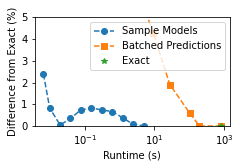

In [26]:
fig, ax = plt.subplots(figsize=(3.5, 2))

ax.plot(sample_results['runtime'], sample_results['fail_prob_error'] * 100, '--o', label='Sample Models')
ax.plot(chunk_results['runtime'], chunk_results['fail_prob_error'] * 100, '--s', label='Batched Predictions')

ax.plot([full_runtime], [0], '*', label='Exact')

ax.set_xscale('log')

ax.set_ylim(0, 5)
ax.set_xlabel('Runtime (s)')
ax.set_ylabel('Difference from Exact (%)')

ax.legend()